In [1]:
import pandas as pd

# Load data
data = pd.read_csv("/content/clinical_notes_diagnosis_prediction_5000.csv")
data

,Clinical Notes,Diagnosis
0,"A 35-year-old male presents with heartburn, re...",Gastroesophageal Reflux Disease
1,A 55-year-old male with a history of heavy alc...,Liver Cirrhosis
2,A 50-year-old male with a history of diabetes ...,Septic Shock
3,"A 35-year-old male presents with heartburn, re...",Gastroesophageal Reflux Disease
4,A 55-year-old female with a history of obesity...,Type 2 Diabetes Mellitus
...,...,...
4995,A 55-year-old male with a history of heavy alc...,Liver Cirrhosis
4996,"A 40-year-old female presents with swelling, p...",Deep Vein Thrombosis
4997,A 55-year-old male with a history of heavy alc...,Liver Cirrhosis
4998,"A 40-year-old female presents with swelling, p...",Deep Vein Thrombosis


In [2]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords') # downloading stopwords
stop_words = set(stopwords.words('english')) # loading them now

def textCleaning(text):
    text = str(text).lower() # converting to string and lowercase the text
    text = re.sub(r'\d+', '', text) # removing any numbers
    text = re.sub(r'[^a-z\s]', '', text) # removing special characters, punctuation and non-alphabetical characters
    text = re.sub(r'\s+', ' ', text).strip() # removing extra spaces
    text = ' '.join([word for word in text.split() if word not in stop_words])  # removing stopwords
    return text

data['Clinical Notes'] = data['Clinical Notes'].apply(textCleaning)
data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Clinical Notes,Diagnosis
0,yearold male presents heartburn regurgitation ...,Gastroesophageal Reflux Disease
1,yearold male history heavy alcohol use present...,Liver Cirrhosis
2,yearold male history diabetes presents hypoten...,Septic Shock
3,yearold male presents heartburn regurgitation ...,Gastroesophageal Reflux Disease
4,yearold female history obesity hypertension pr...,Type 2 Diabetes Mellitus


In [3]:
data['Diagnosis'].value_counts()

,count
Diagnosis,
Peptic Ulcer Disease,284
Type 2 Diabetes Mellitus,283
Acute Myocardial Infarction,272
Chronic Obstructive Pulmonary Disease,269
Cerebrovascular Accident,263
Deep Vein Thrombosis,260
Community-Acquired Pneumonia,251
Chronic Kidney Disease,251
Septic Shock,246


In [4]:
# Label encoding for 'diagnosis' column
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['Diagnosis'] = label_encoder.fit_transform(data['Diagnosis'])

In [5]:
# Split data
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['Clinical Notes'], data['Diagnosis'], test_size=0.2, random_state=42
)

In [6]:
# Train tokenizer from scratch on your dataset
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer
import os

# Create directory if it doesn't exist
os.makedirs("/content/tokenizer", exist_ok=True)

# Initialize a tokenizer
tokenizer = BertWordPieceTokenizer(
    clean_text=True,
    handle_chinese_chars=False,
    strip_accents=False,
    lowercase=True,
)

# Prepare a text file with your training data for tokenizer training
with open("/content/training_texts.txt", "w") as f:
    for text in train_texts:
        f.write(str(text) + "\n")

# Train tokenizer
tokenizer.train(
    files=["/content/training_texts.txt"],
    vocab_size=30522,  # Same as original BERT
    min_frequency=2,
    show_progress=True,
    special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
)

# Save and load as transformers tokenizer
tokenizer.save_model("/content/tokenizer")
transformers_tokenizer = BertTokenizer.from_pretrained("/content/tokenizer")

In [7]:
# Tokenize data
train_encodings = transformers_tokenizer(
    list(train_texts),
    padding=True,
    truncation=True,
    max_length=512
)
test_encodings = transformers_tokenizer(
    list(test_texts),
    padding=True,
    truncation=True,
    max_length=512
)

In [8]:
# Convert to dataset format
from datasets import Dataset

train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels.tolist()
})
test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_labels.tolist()
})

In [9]:
# Initialize BERT model from scratch (not pretrained)
from transformers import BertConfig, BertForSequenceClassification

# Create BERT configuration
config = BertConfig(
    vocab_size=transformers_tokenizer.vocab_size,
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072,
    hidden_act="gelu",
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    max_position_embeddings=512,
    type_vocab_size=2,
    initializer_range=0.02,
    layer_norm_eps=1e-12,
    pad_token_id=0,
    num_labels=len(label_encoder.classes_)
)

# Initialize model from scratch
model = BertForSequenceClassification(config)

In [10]:
# Training arguments - adjusted for training from scratch
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-4,  # Higher learning rate for training from scratch
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,  # More epochs needed for training from scratch
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    lr_scheduler_type="linear",
    warmup_steps=1000,  # More warmup steps
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=3,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,  # Save memory
    fp16=True,  # Mixed precision training for efficiency
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

In [11]:
# Train the model
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 1


wandb: You chose 'Create a W&B account'
wandb: Create an account here: https://wandb.ai/authorize?signup=true&ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rabipkmsn (rabipkmsn-superior-university-lahore) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.015000,0.007616
2,0.002300,0.001594
3,0.000900,0.000651
4,0.000500,0.000333
5,0.000300,0.000195
6,0.000200,0.000124
7,0.000100,0.000084
8,0.000100,0.000060
9,0.000100,0.000048
10,0.000100,0.000044


TrainOutput(global_step=1250, training_loss=0.13290298686921598, metrics={'train_runtime': 271.5361, 'train_samples_per_second': 147.31, 'train_steps_per_second': 4.603, 'total_flos': 986825917440000.0, 'train_loss': 0.13290298686921598, 'epoch': 10.0})

Classification Report:
                                       precision    recall  f1-score   support

          Acute Myocardial Infarction       1.00      1.00      1.00        51
                  Acute Renal Failure       1.00      1.00      1.00        57
                               Asthma       1.00      1.00      1.00        53
             Cerebrovascular Accident       1.00      1.00      1.00        53
               Chronic Kidney Disease       1.00      1.00      1.00        40
Chronic Obstructive Pulmonary Disease       1.00      1.00      1.00        51
         Community-Acquired Pneumonia       1.00      1.00      1.00        48
             Congestive Heart Failure       1.00      1.00      1.00        56
                 Deep Vein Thrombosis       1.00      1.00      1.00        50
      Gastroesophageal Reflux Disease       1.00      1.00      1.00        50
                         Hypertension       1.00      1.00      1.00        40
                      Liver 

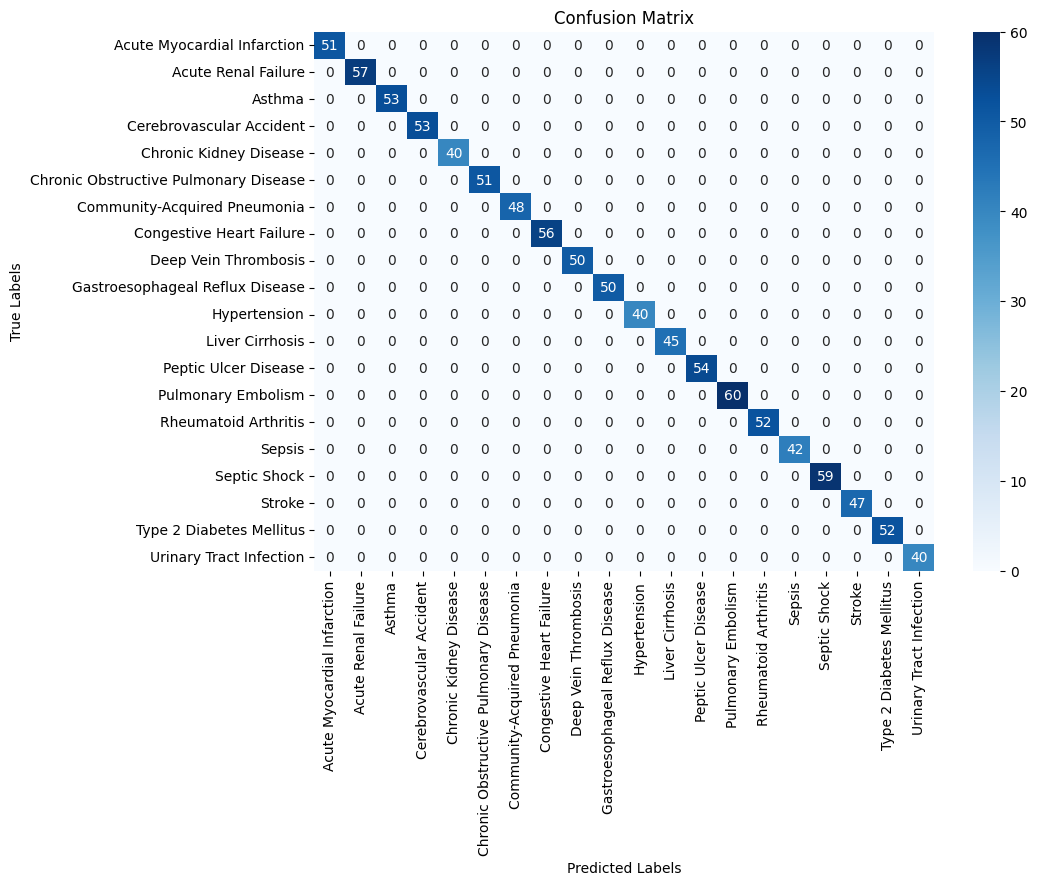

Accuracy: 1.0000
F1 Score: 1.0000


In [12]:
# Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predictions
predictions, labels, _ = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

target_names = [str(label) for label in label_encoder.classes_]

# Classification report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels, target_names=target_names))

# Confusion matrix
cmatrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# Add this to your evaluation
from sklearn.metrics import accuracy_score, f1_score

accuracy = accuracy_score(test_labels, predicted_labels)
f1 = f1_score(test_labels, predicted_labels, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

In [13]:
# Save model and tokenizer
trainer.save_model('./patient_model')
trainer.save_state()
transformers_tokenizer.save_pretrained('./patient_model')

import pickle
pickle.dump(label_encoder, open("label_encoder.pkl", 'wb'))

In [14]:
# Load model for inference
from transformers import BertForSequenceClassification, BertTokenizer
import pickle

model = BertForSequenceClassification.from_pretrained('./patient_model')
tokenizer = BertTokenizer.from_pretrained('./patient_model')

with open("label_encoder.pkl", 'rb') as f:
    label_encoder = pickle.load(f)

In [15]:
# Prediction function
import torch

def predictTheDisease(patient_record, model, tokenizer, label_encoder):
    inputs = tokenizer(patient_record, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
    pred_label_index = torch.argmax(logits, dim=1).item()
    predicted_condition = label_encoder.inverse_transform([pred_label_index])[0]
    return predicted_condition

# Test prediction
patient_record = "Patient presents with fever, headache, and fatigue. Medical history includes hypertension."
predicted_disease = predictTheDisease(patient_record, model, tokenizer, label_encoder)
print(f"Predicted Disease: {predicted_disease}")

Predicted Disease: Pulmonary Embolism


In [16]:
# Another test
patient_record = "'yearold male presents heartburn regurgitation sour taste mouth especially meals patient selfmedicating overthecounter antacids symptoms persist hour ph monitoring test confirms diagnosis gerd patient started ppi advised avoid trigger foods'"
predicted_disease = predictTheDisease(patient_record, model, tokenizer, label_encoder)
print(f"Predicted Disease: {predicted_disease}")

Predicted Disease: Gastroesophageal Reflux Disease


In [17]:
# Download model
import shutil
from google.colab import files
shutil.make_archive('/content/patient_model', 'zip', './patient_model')
files.download('/content/patient_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>